In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import time

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

# Load the train and test sets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import torch

# Load the checkpoint
checkpoint = torch.load('resnet50_ht2.pth')

# Extract the model structure and state dict
model = checkpoint["model"]  # This contains the model architecture
model.load_state_dict(checkpoint["state_dict"])  # Load the saved weights

# Move the model to the appropriate device
model = model.to(device)

# Set model to training mode
model.train()


/tmp/ipykernel_3175/2263318236.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet50_ht2.pth')


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Sequential(
        (0): Conv2d(64, 13, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(13, 18, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
        (2): Conv2d(18, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=Fa

In [6]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [7]:
def validate(model, test_dataloader, criterion):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total_samples = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item() * target.size(0)  # accumulate the total loss

            # Calculate top-1 and top-5 accuracy
            _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
            top5_preds = top5_preds.t()  

            top1_correct += top5_preds[:1].eq(target.view(1, -1)).sum().item()
            top5_correct += top5_preds.eq(target.view(1, -1)).sum().item()
            total_samples += target.size(0)

    top1_accuracy = 100. * top1_correct / total_samples
    top5_accuracy = 100. * top5_correct / total_samples
    val_loss = val_running_loss / total_samples  # calculate average validation loss

    print(f'Validation Loss: {val_loss:.4f}, Top-1 Acc: {top1_accuracy:.2f}, Top-5 Acc: {top5_accuracy:.2f}')
    return val_loss, top1_accuracy, top5_accuracy

In [8]:
def fit(model, train_dataloader, criterion, optimizer):
    model.train()
    train_running_loss = 0.0
    top1_correct = 0
    top5_correct = 0
    total_samples = 0

    for data, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Accumulate the total loss
        train_running_loss += loss.item() * target.size(0)

        # Calculate top-1 and top-5 accuracy
        _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
        top5_preds = top5_preds.t()
        
        top1_correct += top5_preds[:1].eq(target.view(1, -1)).sum().item()
        top5_correct += top5_preds.eq(target.view(1, -1)).sum().item()
        total_samples += target.size(0)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / total_samples  # average train loss
    top1_accuracy = 100. * top1_correct / total_samples
    top5_accuracy = 100. * top5_correct / total_samples

    print(f'Train Loss: {train_loss:.4f}, Top-1 Acc: {top1_accuracy:.2f}, Top-5 Acc: {top5_accuracy:.2f}')
    return train_loss, top1_accuracy, top5_accuracy

In [9]:
train_loss, train_top1_accuracy, train_top5_accuracy = [], [], []
val_loss, val_top1_accuracy, val_top5_accuracy = [], [], []

start = time.time()
for epoch in range(10):
    train_epoch_loss, train_top1_acc, train_top5_acc = fit(model, train_loader, criterion, optimizer)
    val_epoch_loss, val_top1_acc, val_top5_acc = validate(model, test_loader, criterion)
    
    train_loss.append(train_epoch_loss)
    train_top1_accuracy.append(train_top1_acc)
    train_top5_accuracy.append(train_top5_acc)
    val_loss.append(val_epoch_loss)
    val_top1_accuracy.append(val_top1_acc)
    val_top5_accuracy.append(val_top5_acc)

end = time.time()

torch.save(model.state_dict(), 'vgg16_finetuned.pth')
print(f"Training took {(end - start) / 60:.2f} minutes")

# Print final statistics
print(f"Final Train Loss: {train_loss[-1]:.4f}, Top-1 Acc: {train_top1_accuracy[-1]:.2f}, Top-5 Acc: {train_top5_accuracy[-1]:.2f}")
print(f"Final Val Loss: {val_loss[-1]:.4f}, Top-1 Acc: {val_top1_accuracy[-1]:.2f}, Top-5 Acc: {val_top5_accuracy[-1]:.2f}")

Train Loss: 0.6352, Top-1 Acc: 77.65, Top-5 Acc: 98.86
Validation Loss: 0.6086, Top-1 Acc: 79.11, Top-5 Acc: 98.82
Train Loss: 0.6061, Top-1 Acc: 78.61, Top-5 Acc: 98.91
Validation Loss: 0.5959, Top-1 Acc: 79.21, Top-5 Acc: 98.92
Train Loss: 0.5933, Top-1 Acc: 79.09, Top-5 Acc: 99.01
Validation Loss: 0.5897, Top-1 Acc: 79.36, Top-5 Acc: 98.81
Train Loss: 0.5878, Top-1 Acc: 79.34, Top-5 Acc: 98.97
Validation Loss: 0.5886, Top-1 Acc: 79.39, Top-5 Acc: 98.92
Train Loss: 0.5778, Top-1 Acc: 79.85, Top-5 Acc: 99.01
Validation Loss: 0.5728, Top-1 Acc: 79.95, Top-5 Acc: 98.94
Train Loss: 0.5697, Top-1 Acc: 79.93, Top-5 Acc: 99.06
Validation Loss: 0.5776, Top-1 Acc: 79.91, Top-5 Acc: 99.01
Train Loss: 0.5653, Top-1 Acc: 80.16, Top-5 Acc: 99.03
Validation Loss: 0.5666, Top-1 Acc: 80.16, Top-5 Acc: 98.89
Train Loss: 0.5604, Top-1 Acc: 80.52, Top-5 Acc: 99.02
Validation Loss: 0.5676, Top-1 Acc: 80.16, Top-5 Acc: 99.03
Train Loss: 0.5576, Top-1 Acc: 80.55, Top-5 Acc: 99.11
Validation Loss: 0.5569, 

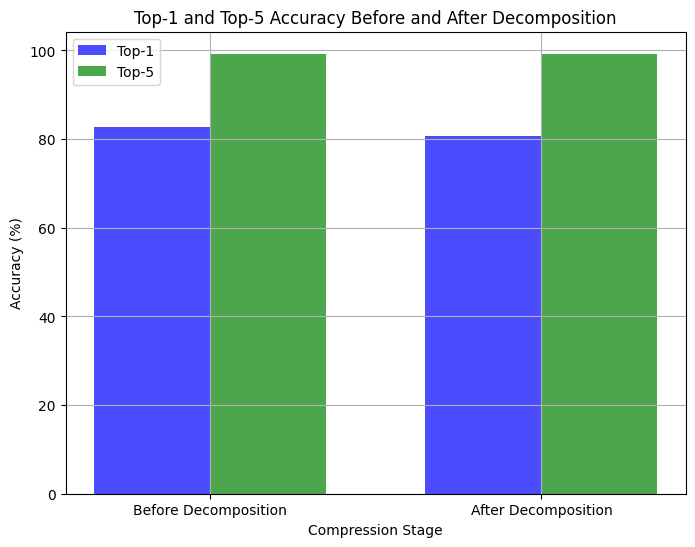

In [4]:
import matplotlib.pyplot as plt

# Data for accuracies before and after decomposition
accuracies = {
    "Top-1 Accuracy": [82.64, 80.80],
    "Top-5 Accuracy": [99.25, 99.14]
}

# Labels for the x-axis (Before and After Decomposition)
labels = ["Before Decomposition", "After Decomposition"]

# Plotting the data as a bar chart
bar_width = 0.35
index = range(len(labels))

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Bar plot for Top-1 and Top-5 accuracies
plt.bar(index, accuracies["Top-1 Accuracy"], bar_width, label="Top-1", color='blue', alpha=0.7)
plt.bar([p + bar_width for p in index], accuracies["Top-5 Accuracy"], bar_width, label="Top-5", color='green', alpha=0.7)

# Adding labels and title
plt.xlabel("Compression Stage")
plt.ylabel("Accuracy (%)")
plt.title("Top-1 and Top-5 Accuracy Before and After Decomposition")

# Adjust the x-axis to show the labels
plt.xticks([p + bar_width / 2 for p in index], labels)

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

